# House Price Prediction (Deep Learning)

**목표**: `TensorFlow/Keras`를 활용하여 주택 가격(`SalePrice`)을 예측하는 딥러닝 모델을 구축하고, 기존 Tree 모델과 성능을 비교합니다.
**데이터셋**: `data/house_train.csv`
**작성자**: AI Assistant
**날짜**: 2026-01-09

## 1. 환경 설정 및 데이터 로드
- 딥러닝을 위한 `TensorFlow`, `Keras` 라이브러리를 로드합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 시각화 설정
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)
np.random.seed(42)
tf.random.set_seed(42)

/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
df_train = pd.read_csv('../../data/house_train.csv')
print(f"Data Shape: {df_train.shape}")

Data Shape: (1460, 81)


## 2. 타겟 변수 변환 (Log Transformation)
딥러닝의 수렴을 돕기 위해 타겟 변수(`SalePrice`)를 로그 변환하여 분포를 정규화합니다.

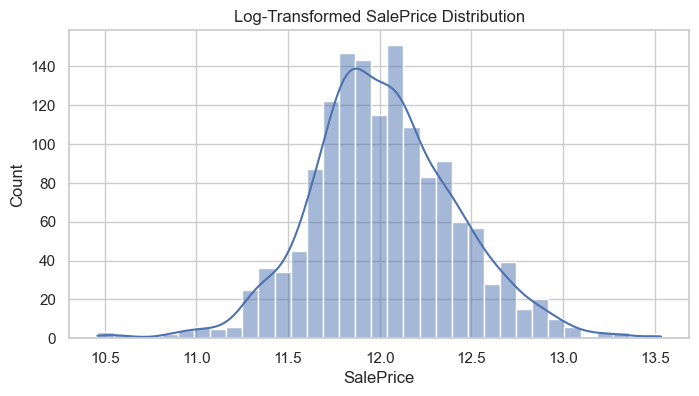

In [3]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

plt.figure(figsize=(8, 4))
sns.histplot(df_train['SalePrice'], kde=True)
plt.title("Log-Transformed SalePrice Distribution")
plt.show()

## 3. 데이터 전처리 (Preprocessing)
딥러닝 모델은 입력 데이터의 스케일에 매우 민감합니다. 따라서 **결측치 처리 -> One-Hot Encoding -> Standard Scaling** 순서로 전처리를 수행합니다.

In [4]:
# ID 제거
df_train.drop("Id", axis=1, inplace=True)

# 1. Meaningful NA 처리 (시설 없음)
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in none_cols:
    df_train[col] = df_train[col].fillna("None")

# 2. 수치형 변수 결측치 대치 (0 또는 중앙값)
df_train['LotFrontage'] = df_train.groupby("Neighborhood")['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))
    
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df_train[col] = df_train[col].fillna(0)

# 나머지 수치형 -> 0
for col in df_train.select_dtypes(include=[np.number]).columns:
    df_train[col] = df_train[col].fillna(0)

# 3. 나머지 범주형 -> Mode
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

print(f"남은 결측치: {df_train.isnull().sum().sum()}")

남은 결측치: 0


### 3.1 Encoding & Scaling
- **One-Hot Encoding**: 모든 범주형 변수를 0/1 벡터로 변환 (딥러닝 권장).
- **StandardScaler**: 모든 수치형 변수를 평균 0, 분산 1로 변환.

In [5]:
# One-Hot Encoding
df_train = pd.get_dummies(df_train)
print(f"Encoded Shape: {df_train.shape}")

# X, y 분리
y = df_train['SalePrice'].values
X = df_train.drop(['SalePrice'], axis=1)

# Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling (Train 데이터 기준으로 Fit)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

print(f"Train Feature Shape: {X_train.shape}")

Encoded Shape: (1460, 302)
Train Feature Shape: (1168, 301)


## 4. 딥러닝 모델링 (Deep Learning Modeling)
- **구조**: Input -> Dense(256) -> Dense(128) -> Dense(64) -> Dense(32) -> Output(1)
- **기법**: `ReLU` 활성화 함수, `Dropout`(과적합 방지), `Adam` 옵티마이저.

In [6]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    
    Dense(1)  # Regression Output
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

/Users/bagjongman/.pyenv/versions/3.12.8/lib/python3.12/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-09 13:04:20.095186: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2026-01-09 13:04:20.095214: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2026-01-09 13:04:20.095222: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 25.92 GB
2026-01-09 13:04:20.095239: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-09 13:04:20.095249: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        77,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,369 (478.00 KB)

 Trainable params: 121,473 (474.50 KB)

 Non-trainable params: 896 (3.50 KB)

## 5. 학습 및 검증 (Training & Verification)
- `EarlyStopping`: 20 Epoch 동안 성능 향상이 없으면 중단.
- `ModelCheckpoint`: 검증 손실(val_loss)이 가장 낮은 모델 저장.

In [7]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
mc = ModelCheckpoint('./model/best_house_dl_model.keras', monitor='val_loss', save_best_only=True)

# Training
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=200, 
                    batch_size=32, 
                    callbacks=[es, mc],
                    verbose=1)

Epoch 1/200


2026-01-09 13:04:21.095752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 1/37 ━━━━━━━━━━━━━━━━━━━━ 2:09 4s/step - loss: 144.3352 - mae: 11.8598

 3/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 146.6470 - mae: 11.9683

 5/37 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 146.8362 - mae: 11.9867

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 146.7020 - mae: 11.9842

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 146.5389 - mae: 11.9782

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 146.5455 - mae: 11.9783

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 146.4676 - mae: 11.9754

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 146.2104 - mae: 11.9659

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 146.0242 - mae: 11.9590

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 145.8061 - mae: 11.9506

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 145.5917 - mae: 11.9424

26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 145.3961 - mae: 11.9348

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 145.0793 - mae: 11.9224

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 144.7817 - mae: 11.9108

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 144.4952 - mae: 11.8997

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 144.3167 - mae: 11.8927

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 141.1192 - mae: 11.7673 - val_loss: 128.2191 - val_mae: 11.2225


Epoch 2/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 128.5165 - mae: 11.2347

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 130.8727 - mae: 11.3303

 5/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 130.6422 - mae: 11.3204

 6/37 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 130.5187 - mae: 11.3118

 8/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 130.3848 - mae: 11.3037

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 130.3338 - mae: 11.2989

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 130.2409 - mae: 11.2932

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 130.0597 - mae: 11.2851

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 129.8960 - mae: 11.2781

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 129.7317 - mae: 11.2709

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 129.4917 - mae: 11.2600

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 129.2436 - mae: 11.2486

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 128.9988 - mae: 11.2372

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 128.7624 - mae: 11.2264

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 128.5319 - mae: 11.2159

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 128.3751 - mae: 11.2086

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 128.2259 - mae: 11.2017

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 125.5552 - mae: 11.0778 - val_loss: 112.9753 - val_mae: 10.5138


Epoch 3/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 112.6661 - mae: 10.4226

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 115.1364 - mae: 10.5797

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 115.1207 - mae: 10.5854

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 114.7564 - mae: 10.5694

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 114.2598 - mae: 10.5483

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 113.7956 - mae: 10.5284

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 113.4792 - mae: 10.5147

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 113.0660 - mae: 10.4971

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 112.6815 - mae: 10.4807

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 112.2924 - mae: 10.4637

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 112.0245 - mae: 10.4518

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 111.7429 - mae: 10.4390

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 111.3133 - mae: 10.4193

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 110.8802 - mae: 10.3991

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 105.6913 - mae: 10.1558 - val_loss: 94.0742 - val_mae: 9.4059


Epoch 4/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 92.8713 - mae: 9.4777

 3/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 94.6654 - mae: 9.5672

 6/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 94.2379 - mae: 9.5538

 8/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 93.5583 - mae: 9.5197

11/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 92.5768 - mae: 9.4706

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 91.5821 - mae: 9.4189

17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 90.6714 - mae: 9.3707

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 89.8360 - mae: 9.3262

23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 89.0274 - mae: 9.2824

26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 88.2580 - mae: 9.2407

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 87.5574 - mae: 9.2019

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 86.8896 - mae: 9.1643

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 86.2742 - mae: 9.1285

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 78.7625 - mae: 8.6914 - val_loss: 58.7261 - val_mae: 7.5453


Epoch 5/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 52.3673 - mae: 7.0278

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 55.5013 - mae: 7.2490

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 56.3659 - mae: 7.2904

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 56.7335 - mae: 7.3027

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 56.7098 - mae: 7.2943

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 56.5984 - mae: 7.2791

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 56.2794 - mae: 7.2515

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 55.8621 - mae: 7.2174

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 55.3836 - mae: 7.1794

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 55.0498 - mae: 7.1534

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 54.6910 - mae: 7.1252

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 54.1534 - mae: 7.0831

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 53.6039 - mae: 7.0392

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 46.6898 - mae: 6.4809 - val_loss: 29.8458 - val_mae: 5.2527


Epoch 6/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 35.9272 - mae: 5.5072

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 33.1816 - mae: 5.2357

 6/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 32.6864 - mae: 5.1927

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 32.0575 - mae: 5.1354

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 31.7325 - mae: 5.1002

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 31.5789 - mae: 5.0811

17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 31.3027 - mae: 5.0533

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 31.0663 - mae: 5.0311

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 30.8128 - mae: 5.0074

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 30.4373 - mae: 4.9720

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 30.0490 - mae: 4.9325

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 29.7000 - mae: 4.8969

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 29.4902 - mae: 4.8752

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 29.1739 - mae: 4.8427

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 25.1367 - mae: 4.4122 - val_loss: 10.6233 - val_mae: 3.1055


Epoch 7/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 12.8366 - mae: 3.1591

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 17.0267 - mae: 3.5054

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17.4308 - mae: 3.5399

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17.4696 - mae: 3.5354

11/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17.5420 - mae: 3.5291

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17.5214 - mae: 3.5063

17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17.3607 - mae: 3.4720

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17.1848 - mae: 3.4398

23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 17.0045 - mae: 3.4090

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16.8832 - mae: 3.3890

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16.7828 - mae: 3.3723

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16.6458 - mae: 3.3508

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16.5224 - mae: 3.3307

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 16.4015 - mae: 3.3127

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 14.9882 - mae: 3.1066 - val_loss: 5.2678 - val_mae: 1.8755


Epoch 8/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 9.7110 - mae: 2.4540

 3/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.1058 - mae: 2.6079

 6/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.0544 - mae: 2.5945

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.3928 - mae: 2.6199

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.5488 - mae: 2.6354

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.6607 - mae: 2.6464

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.7466 - mae: 2.6549

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.8195 - mae: 2.6621

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.8480 - mae: 2.6648

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.8997 - mae: 2.6685

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.9512 - mae: 2.6725

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.9707 - mae: 2.6735

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.9686 - mae: 2.6724

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.9780 - mae: 2.6717

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 12.1610 - mae: 2.6619 - val_loss: 2.0874 - val_mae: 1.2284


Epoch 9/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 14.9954 - mae: 2.8263

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.7109 - mae: 2.7325

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.2640 - mae: 2.7362

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.0849 - mae: 2.7291

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.7858 - mae: 2.7081

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.6214 - mae: 2.6952

17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.3670 - mae: 2.6729

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.1502 - mae: 2.6521

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.0169 - mae: 2.6384

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.9076 - mae: 2.6267

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.7410 - mae: 2.6081

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.6304 - mae: 2.5957

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.5414 - mae: 2.5865

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.5047 - mae: 2.5831

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.4671 - mae: 2.5795

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 10.7596 - mae: 2.5097 - val_loss: 1.2618 - val_mae: 0.9448


Epoch 10/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 9.1852 - mae: 2.5566

 3/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 10.6461 - mae: 2.5552

 5/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.6927 - mae: 2.6187

 8/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.7967 - mae: 2.6045

11/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.5363 - mae: 2.5710

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.3898 - mae: 2.5574

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.3667 - mae: 2.5565

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.3204 - mae: 2.5518

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.2859 - mae: 2.5494

23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.2101 - mae: 2.5392

26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.1178 - mae: 2.5271

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.0520 - mae: 2.5189

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.0130 - mae: 2.5135

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.0026 - mae: 2.5080

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.9977 - mae: 2.5045

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 10.9386 - mae: 2.4464 - val_loss: 1.9570 - val_mae: 1.1196


Epoch 11/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.5180 - mae: 2.4485

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.9481 - mae: 2.6181

 6/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.2867 - mae: 2.6277

 8/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.2705 - mae: 2.6113

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.1173 - mae: 2.5851

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.0753 - mae: 2.5770

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.1572 - mae: 2.5840

17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.2274 - mae: 2.5847

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.2744 - mae: 2.5860

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.3522 - mae: 2.5855

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.4185 - mae: 2.5855

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.4628 - mae: 2.5842

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.5122 - mae: 2.5840

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.5413 - mae: 2.5833

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.5548 - mae: 2.5819

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 11.6144 - mae: 2.5560 - val_loss: 0.7850 - val_mae: 0.8234


Epoch 12/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.1856 - mae: 2.1585

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.3012 - mae: 2.2201

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.2831 - mae: 2.2018

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.3694 - mae: 2.1984

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.6790 - mae: 2.2121

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.8413 - mae: 2.2191

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.8960 - mae: 2.2210

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.9434 - mae: 2.2224

23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.0131 - mae: 2.2252

26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1244 - mae: 2.2349

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.2589 - mae: 2.2488

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.3610 - mae: 2.2594

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.4423 - mae: 2.2683

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 10.4535 - mae: 2.3871 - val_loss: 2.9912 - val_mae: 1.3942


Epoch 13/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 12.7494 - mae: 2.4901

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.3307 - mae: 2.4185

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.5589 - mae: 2.3691

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.3137 - mae: 2.3568

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.3886 - mae: 2.3712

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.5077 - mae: 2.3868

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.5905 - mae: 2.3989

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.6735 - mae: 2.4095

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.7379 - mae: 2.4135

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.7691 - mae: 2.4158

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.7833 - mae: 2.4175

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.7907 - mae: 2.4196

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.8097 - mae: 2.4225

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 10.8954 - mae: 2.4439 - val_loss: 3.8681 - val_mae: 1.6304


Epoch 14/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 12.3303 - mae: 2.9056

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.0166 - mae: 2.5433

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.3437 - mae: 2.3944 

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.0362 - mae: 2.3343

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1185 - mae: 2.3293

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1731 - mae: 2.3272

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1964 - mae: 2.3215

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.2245 - mae: 2.3206

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.2422 - mae: 2.3182

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.2367 - mae: 2.3125

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.2206 - mae: 2.3040

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.2228 - mae: 2.3002

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.2333 - mae: 2.2981

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.2753 - mae: 2.2990

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.3372 - mae: 2.3004

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 10.1095 - mae: 2.3258 - val_loss: 1.5220 - val_mae: 0.9698


Epoch 15/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.5649 - mae: 2.3410

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.2963 - mae: 2.1688

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.1872 - mae: 2.1479

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0671 - mae: 2.1244

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.1514 - mae: 2.1092

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.2137 - mae: 2.1036

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.2943 - mae: 2.1072

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.4508 - mae: 2.1169

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.5763 - mae: 2.1244

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.7073 - mae: 2.1340

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.7826 - mae: 2.1400

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.8676 - mae: 2.1473

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.9250 - mae: 2.1525

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.5672 - mae: 2.2133 - val_loss: 1.1301 - val_mae: 0.8758


Epoch 16/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.1448 - mae: 1.9639

 3/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7.4165 - mae: 2.0960

 5/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.0016 - mae: 2.2312

 8/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.5632 - mae: 2.2806

11/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 9.8168 - mae: 2.3061

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.9121 - mae: 2.3205

17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8981 - mae: 2.3202

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8840 - mae: 2.3173

23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8993 - mae: 2.3160

26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8906 - mae: 2.3139

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8720 - mae: 2.3121

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8549 - mae: 2.3102

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8356 - mae: 2.3080

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8298 - mae: 2.3078

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.7457 - mae: 2.3085 - val_loss: 4.4591 - val_mae: 1.7434


Epoch 17/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 13.7188 - mae: 2.5921

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.6808 - mae: 2.6689

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.7246 - mae: 2.5732

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.5163 - mae: 2.5653

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.3434 - mae: 2.5506

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.2873 - mae: 2.5434

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.2463 - mae: 2.5374

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.1843 - mae: 2.5266

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.1330 - mae: 2.5163

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.0969 - mae: 2.5062

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.0568 - mae: 2.4972

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.0127 - mae: 2.4888

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.9708 - mae: 2.4810

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 10.4607 - mae: 2.3924 - val_loss: 2.5022 - val_mae: 1.3015


Epoch 18/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 10.1363 - mae: 2.2499

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1100 - mae: 2.2063 

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2170 - mae: 2.2255

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2381 - mae: 2.2330

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2703 - mae: 2.2452

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2238 - mae: 2.2438

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2181 - mae: 2.2463

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1865 - mae: 2.2450

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1677 - mae: 2.2440

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1434 - mae: 2.2433

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1489 - mae: 2.2448

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1813 - mae: 2.2488

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2216 - mae: 2.2533

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.7209 - mae: 2.3080 - val_loss: 1.3690 - val_mae: 0.9036


Epoch 19/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.6383 - mae: 2.1678

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.4217 - mae: 2.2809

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.3017 - mae: 2.3796

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.7455 - mae: 2.4177

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.9580 - mae: 2.4339

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.9978 - mae: 2.4402

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.0200 - mae: 2.4443

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.0224 - mae: 2.4448

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.9692 - mae: 2.4389

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.9097 - mae: 2.4314

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.8565 - mae: 2.4254

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.7994 - mae: 2.4184

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.7647 - mae: 2.4138

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 10.3733 - mae: 2.3684 - val_loss: 1.4862 - val_mae: 0.9369


Epoch 20/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.6220 - mae: 2.2568

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.4004 - mae: 2.4950

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.1477 - mae: 2.5166

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.0041 - mae: 2.4755

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.9716 - mae: 2.4658

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.8317 - mae: 2.4445

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.6876 - mae: 2.4261

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.6025 - mae: 2.4162

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.5182 - mae: 2.4054

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.4497 - mae: 2.3963

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.3717 - mae: 2.3873

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.2909 - mae: 2.3778

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.2126 - mae: 2.3681

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.2699 - mae: 2.2522 - val_loss: 0.6765 - val_mae: 0.7709


Epoch 21/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.0040 - mae: 2.0427

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.9987 - mae: 2.1803

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.9923 - mae: 2.1755

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.1316 - mae: 2.1773

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.3064 - mae: 2.1874

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.5264 - mae: 2.2065

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.7163 - mae: 2.2209

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.8696 - mae: 2.2331

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.9930 - mae: 2.2425

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1030 - mae: 2.2506

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2164 - mae: 2.2607

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2906 - mae: 2.2667

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.3574 - mae: 2.2722

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 10.1006 - mae: 2.3310 - val_loss: 3.3589 - val_mae: 1.4529


Epoch 22/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 17.6773 - mae: 3.1734

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.2918 - mae: 2.7803

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.8431 - mae: 2.6009

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.1798 - mae: 2.5143

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.8080 - mae: 2.4640

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.5143 - mae: 2.4248

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.2542 - mae: 2.3901

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.0317 - mae: 2.3596

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8964 - mae: 2.3392 

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.7996 - mae: 2.3249

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.7375 - mae: 2.3146

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.6845 - mae: 2.3064

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.6447 - mae: 2.3003

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.1732 - mae: 2.2267 - val_loss: 0.9057 - val_mae: 0.8894


Epoch 23/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 15.7557 - mae: 3.0766

 3/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.8942 - mae: 2.6038

 6/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.1019 - mae: 2.3868

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.4344 - mae: 2.3033 

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.2474 - mae: 2.2754

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1941 - mae: 2.2687

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1275 - mae: 2.2618

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.0803 - mae: 2.2589

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.0424 - mae: 2.2560

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.0149 - mae: 2.2537

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.9970 - mae: 2.2520

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.9818 - mae: 2.2506

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.9672 - mae: 2.2492

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 8.8672 - mae: 2.2350 - val_loss: 1.5113 - val_mae: 0.9629


Epoch 24/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 13.8150 - mae: 2.9362

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.4353 - mae: 2.6039

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.7958 - mae: 2.5745

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.8626 - mae: 2.5630

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.7612 - mae: 2.5424

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.6899 - mae: 2.5358

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.5647 - mae: 2.5254

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.4252 - mae: 2.5115

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.3171 - mae: 2.5016

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.2296 - mae: 2.4941

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.1724 - mae: 2.4895

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.1192 - mae: 2.4852

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.0697 - mae: 2.4815

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 10.4979 - mae: 2.4340 - val_loss: 1.7297 - val_mae: 1.0257


Epoch 25/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.6875 - mae: 2.0779

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.4776 - mae: 2.2013

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 8.5810 - mae: 2.2322

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.0388 - mae: 2.2702

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2528 - mae: 2.2897

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.4299 - mae: 2.3105

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.5733 - mae: 2.3257

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.6447 - mae: 2.3319

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.6984 - mae: 2.3362

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.7352 - mae: 2.3396

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.7549 - mae: 2.3419

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.7541 - mae: 2.3419

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.7563 - mae: 2.3433

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.7966 - mae: 2.3602 - val_loss: 1.0469 - val_mae: 0.9071


Epoch 26/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 7.6627 - mae: 2.0335

 3/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.5417 - mae: 2.1214

 5/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.2104 - mae: 2.2228

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.4877 - mae: 2.2691

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.7187 - mae: 2.3043

11/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.8108 - mae: 2.3205

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 9.7893 - mae: 2.3222

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.7322 - mae: 2.3182

17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.7742 - mae: 2.3227

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.8511 - mae: 2.3325

23/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.9717 - mae: 2.3459

26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 10.0708 - mae: 2.3582

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.1311 - mae: 2.3653

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.1656 - mae: 2.3709

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 10.2084 - mae: 2.3760

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 10.4915 - mae: 2.4172 - val_loss: 2.4165 - val_mae: 1.1776


Epoch 27/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 12.7580 - mae: 2.8410

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.8448 - mae: 2.4348 

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.8222 - mae: 2.3688

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.8588 - mae: 2.3640

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.7908 - mae: 2.3538

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.8093 - mae: 2.3497

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.8130 - mae: 2.3476

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.8277 - mae: 2.3484

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.8552 - mae: 2.3523

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.9065 - mae: 2.3581

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.9967 - mae: 2.3679

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.0823 - mae: 2.3777

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.1633 - mae: 2.3872

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 11.0633 - mae: 2.4909 - val_loss: 5.0349 - val_mae: 1.8112


Epoch 28/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 18.0130 - mae: 3.2250

 3/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 16.9129 - mae: 3.0934

 6/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 15.3533 - mae: 2.8876

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 14.1303 - mae: 2.7556

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 13.3186 - mae: 2.6742

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.7743 - mae: 2.6230

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.3953 - mae: 2.5873

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.1199 - mae: 2.5621

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.8657 - mae: 2.5365

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.6362 - mae: 2.5134

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.4356 - mae: 2.4931

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.2774 - mae: 2.4764

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.1638 - mae: 2.4646

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.8510 - mae: 2.3334 - val_loss: 10.7296 - val_mae: 2.7746


Epoch 29/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 16.0613 - mae: 3.3132

 3/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 12.9700 - mae: 2.8342

 6/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 11.8359 - mae: 2.6653

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.5809 - mae: 2.6063

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.4598 - mae: 2.5785

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.3031 - mae: 2.5535

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.1890 - mae: 2.5388

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.0262 - mae: 2.5177

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.8928 - mae: 2.5009

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.7973 - mae: 2.4886

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.7380 - mae: 2.4806

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.6922 - mae: 2.4743

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.6545 - mae: 2.4685

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 10.1633 - mae: 2.3952 - val_loss: 6.2929 - val_mae: 2.0530


Epoch 30/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 8.8198 - mae: 2.2894

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.1253 - mae: 2.5842

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.9266 - mae: 2.5505

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.0821 - mae: 2.5490

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.2316 - mae: 2.5555

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.2703 - mae: 2.5583

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.2683 - mae: 2.5571

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.2611 - mae: 2.5561

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.2697 - mae: 2.5550

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.3737 - mae: 2.5636

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.4644 - mae: 2.5701

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.5404 - mae: 2.5753

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.6186 - mae: 2.5818

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 12.7422 - mae: 2.6847 - val_loss: 1.7314 - val_mae: 1.1605


Epoch 31/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 12.1572 - mae: 2.6446

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 13.2392 - mae: 2.7293

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.7283 - mae: 2.7883

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.6059 - mae: 2.7829

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.7901 - mae: 2.7881

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.7385 - mae: 2.7691

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.5420 - mae: 2.7389

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.3456 - mae: 2.7109

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.1682 - mae: 2.6864

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13.0367 - mae: 2.6680

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.9059 - mae: 2.6508

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.7726 - mae: 2.6352

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.6559 - mae: 2.6217

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 11.2994 - mae: 2.4627 - val_loss: 1.5841 - val_mae: 1.1720


Epoch 32/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9.9740 - mae: 2.4852

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.4657 - mae: 2.4411

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.6128 - mae: 2.4349

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.6818 - mae: 2.4297

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.7166 - mae: 2.4351

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.6935 - mae: 2.4321

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.5945 - mae: 2.4198

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.4539 - mae: 2.4018

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.3321 - mae: 2.3862

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.2369 - mae: 2.3735

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.1510 - mae: 2.3617

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.0996 - mae: 2.3535

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.0636 - mae: 2.3469

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.6606 - mae: 2.2683 - val_loss: 6.8408 - val_mae: 2.1358


Epoch 33/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.9834 - mae: 2.1201

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1957 - mae: 2.3195

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.5210 - mae: 2.3632

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.5920 - mae: 2.3856

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.7077 - mae: 2.4025

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.9152 - mae: 2.4223

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.0394 - mae: 2.4336

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.1045 - mae: 2.4390

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.1813 - mae: 2.4447

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.2539 - mae: 2.4484

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.3364 - mae: 2.4564

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.3987 - mae: 2.4631

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.4412 - mae: 2.4681

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 11.0343 - mae: 2.5416 - val_loss: 2.1203 - val_mae: 1.2652


Epoch 34/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 9.0622 - mae: 2.3944

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.5324 - mae: 2.4656

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 10.4844 - mae: 2.3492

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.0469 - mae: 2.3041

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.7606 - mae: 2.2819 

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.5595 - mae: 2.2698

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.3837 - mae: 2.2555

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.2866 - mae: 2.2467

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.2245 - mae: 2.2408

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.2019 - mae: 2.2389

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1680 - mae: 2.2359

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1350 - mae: 2.2338

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 9.1117 - mae: 2.2333

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 8.8819 - mae: 2.2349 - val_loss: 1.7704 - val_mae: 1.2349


Epoch 35/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.2356 - mae: 2.1968

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.5343 - mae: 2.1832

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.9576 - mae: 2.2205

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.8919 - mae: 2.2018

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9183 - mae: 2.1997

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.9748 - mae: 2.2013

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.9720 - mae: 2.1963

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.9414 - mae: 2.1879

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.9082 - mae: 2.1794

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.8700 - mae: 2.1698

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.8319 - mae: 2.1616

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.8150 - mae: 2.1576

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.7969 - mae: 2.1524

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.6381 - mae: 2.0993 - val_loss: 1.4028 - val_mae: 1.0748


Epoch 36/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 7.9189 - mae: 2.0908

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.4644 - mae: 2.0660

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.9165 - mae: 2.1454

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9876 - mae: 2.1613

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0634 - mae: 2.1765

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0880 - mae: 2.1846

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0543 - mae: 2.1818

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0084 - mae: 2.1767

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9511 - mae: 2.1693

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.8914 - mae: 2.1617

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.8406 - mae: 2.1548

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.8081 - mae: 2.1507

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.7908 - mae: 2.1483

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 7.5750 - mae: 2.1181 - val_loss: 1.7919 - val_mae: 1.0895


Epoch 37/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 9.6730 - mae: 2.1747

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.7222 - mae: 2.1318

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.3265 - mae: 2.0921

10/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.1642 - mae: 2.0707

13/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.1027 - mae: 2.0674

16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.0494 - mae: 2.0639

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9688 - mae: 2.0565

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9385 - mae: 2.0594

25/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.9033 - mae: 2.0578

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.8462 - mae: 2.0523

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.7891 - mae: 2.0468

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.7330 - mae: 2.0420

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.6765 - mae: 2.0371

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.9963 - mae: 1.9784 - val_loss: 1.3642 - val_mae: 1.1063


Epoch 38/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 6.6389 - mae: 1.9264

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.6945 - mae: 1.7899

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.6641 - mae: 1.7828

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.7717 - mae: 1.7892

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.8587 - mae: 1.8023

15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.8919 - mae: 1.8116

18/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.9235 - mae: 1.8207

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.9148 - mae: 1.8241

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.8835 - mae: 1.8234

27/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.8443 - mae: 1.8206

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.8252 - mae: 1.8201

31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.8111 - mae: 1.8199

33/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.7980 - mae: 1.8198

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.7816 - mae: 1.8200

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.6336 - mae: 1.8261 - val_loss: 1.5207 - val_mae: 0.9921


Epoch 39/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4.1033 - mae: 1.5913

 3/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.2880 - mae: 1.6460

 6/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.1873 - mae: 1.6107

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3245 - mae: 1.6179

12/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.4000 - mae: 1.6258

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.4271 - mae: 1.6268

17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.4735 - mae: 1.6294

20/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.5345 - mae: 1.6375

22/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.5710 - mae: 1.6423

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.6045 - mae: 1.6461

26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.6273 - mae: 1.6489

28/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.6550 - mae: 1.6530

30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.6807 - mae: 1.6566

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7071 - mae: 1.6610

34/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7316 - mae: 1.6651

36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7487 - mae: 1.6681

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 5.0224 - mae: 1.7159 - val_loss: 1.2726 - val_mae: 0.9267


Epoch 40/200


 1/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.3654 - mae: 1.4512

 4/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7402 - mae: 1.6995

 7/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7899 - mae: 1.7080

 9/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7920 - mae: 1.7067

11/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8143 - mae: 1.7089

14/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8415 - mae: 1.7157

17/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8464 - mae: 1.7186

19/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.8262 - mae: 1.7156

21/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.8041 - mae: 1.7120

24/37 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7781 - mae: 1.7067

26/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7616 - mae: 1.7029

29/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7538 - mae: 1.6994

32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7445 - mae: 1.6956

35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.7289 - mae: 1.6912

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.4802 - mae: 1.6374 - val_loss: 1.1813 - val_mae: 0.8898


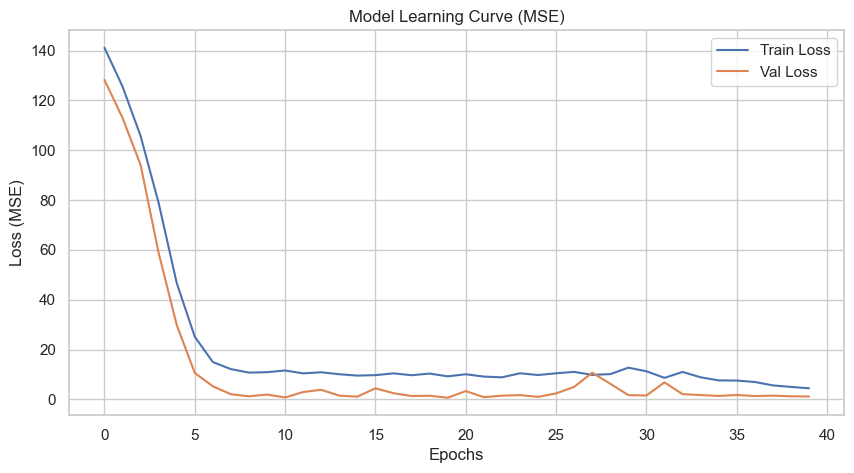

In [8]:
# 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Learning Curve (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

## 6. 최종 평가 (Final Evaluation)
저장된 Best Model을 로드하여 최종 RMSLE 성능을 확인합니다.

In [9]:
# Best Model 로드
best_model = load_model('./model/best_house_dl_model.keras')

# 예측
pred = best_model.predict(X_val)

# RMSLE (Root Mean Squared Error on Log-Transformed Data)
rmsle = np.sqrt(mean_squared_error(y_val, pred))
print(f"Deep Learning Best Model RMSLE: {rmsle:.4f}")

 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Deep Learning Best Model RMSLE: 0.8225
